In [84]:
%load_ext autoreload
%autoreload 2

import glob
import pickle
import chess
import numpy as np
import pandas as pd
from PIL import Image
from tensorflow import keras
from collections import Counter
import matplotlib.pyplot as plt
from cam_chess import predict

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [29]:
X, y = [], []

for key in ['empty', 'white', 'black']:
    data = [np.array(Image.open(path)) for path in glob.glob(f'data/{key}/*.png')]
    X += data
    if key != 'empty':
        # Simple augmentation consisting of mirror images
        X += [im[:, ::-1] for im in data]
    y += [0] * len(data) if key == 'empty' else [1 if key == 'white' else 2] * len(data) * 2
    
X = np.stack(X)
y = np.array(y)

Counter(y)

Counter({0: 832, 1: 832, 2: 832})

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 100, 100, 3)]     0         
_________________________________________________________________
mobilenet_1.00_224 (Function (None, 3, 3, 1024)        3228864   
_________________________________________________________________
flatten_2 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)                589888    
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_3 (Dropout)          (None, 32)                0   

2022-01-04 00:10:29.767530: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


78/78 [==============================] - 9s 102ms/step - loss: 0.6720 - accuracy: 0.7841
Epoch 2/20
78/78 [==============================] - 8s 99ms/step - loss: 0.2970 - accuracy: 0.8930
Epoch 3/20
78/78 [==============================] - 8s 98ms/step - loss: 0.1923 - accuracy: 0.9379
Epoch 4/20
78/78 [==============================] - 8s 100ms/step - loss: 0.1458 - accuracy: 0.9523
Epoch 5/20
78/78 [==============================] - 8s 100ms/step - loss: 0.1536 - accuracy: 0.9615
Epoch 6/20
78/78 [==============================] - 8s 100ms/step - loss: 0.1791 - accuracy: 0.9631
Epoch 7/20
78/78 [==============================] - 8s 100ms/step - loss: 0.1478 - accuracy: 0.9507
Epoch 8/20
78/78 [==============================] - 8s 100ms/step - loss: 0.1077 - accuracy: 0.9667
Epoch 9/20
78/78 [==============================] - 8s 100ms/step - loss: 0.0722 - accuracy: 0.9796
Epoch 10/20
78/78 [==============================] - 8s 99ms/step - loss: 0.1003 - accuracy: 0.9696
Epoch 11/20
7

<AxesSubplot:>

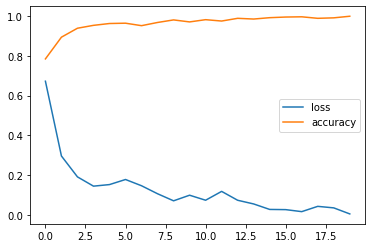

In [52]:
mobile_net = keras.applications.MobileNet(weights='imagenet', include_top=False, input_shape=(100, 100, 3))
inputs = keras.layers.Input(shape=(100, 100, 3))
embedding = mobile_net(inputs)
output = keras.layers.Flatten()(embedding)
output = keras.layers.Dense(64, activation='relu')(output)
output = keras.layers.Dropout(0.4)(output)
output = keras.layers.Dense(32, activation='relu')(output)
output = keras.layers.Dropout(0.4)(output)
output = keras.layers.Dense(3, activation='softmax')(output)
model = keras.models.Model(inputs=inputs, outputs=output)
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

hist = model.fit(X, y, epochs=20)
pd.DataFrame(hist.history).plot()

In [53]:
model.save('3_class_model.h5')

# Test on a simple test game

In [54]:
test = pickle.load(open('simple_test_game.pkl', 'rb'))

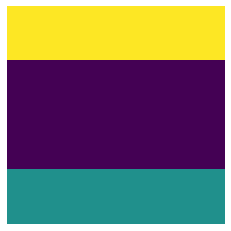

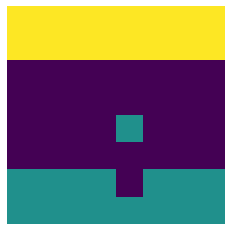

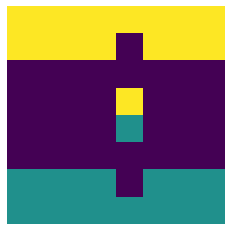

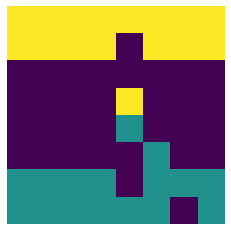

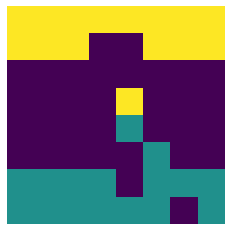

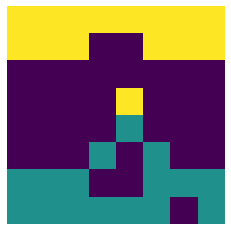

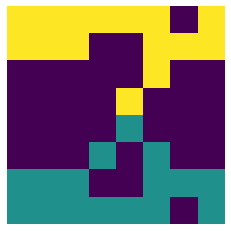

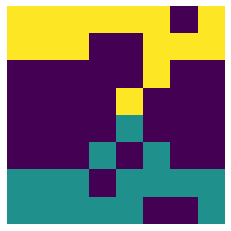

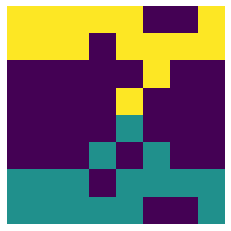

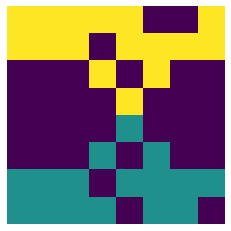

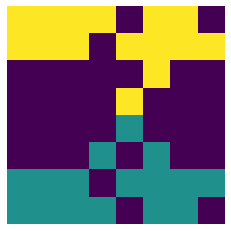

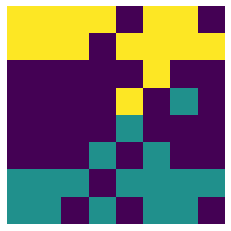

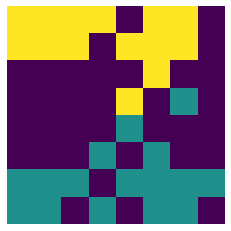

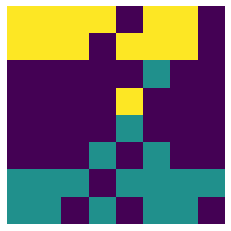

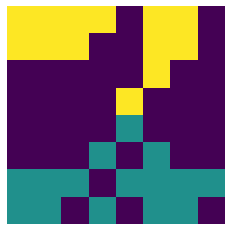

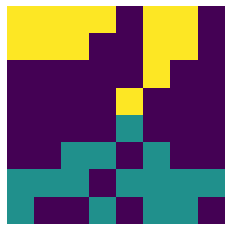

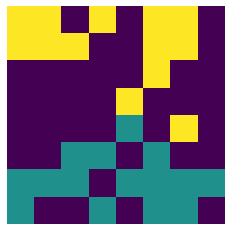

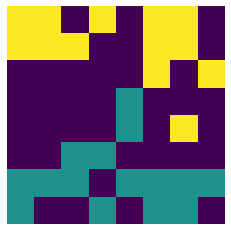

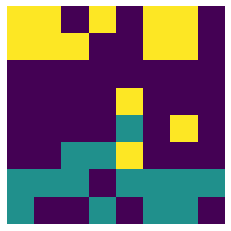

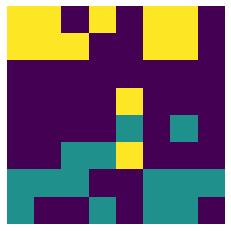

In [55]:
for fields in test['captures']:
    predict(model, fields)

On whites model works stunningly well and fails only on black moves. More training data should help us resolve this issue. Instead for now I simply retrained the model using all the data we have since using 30% for validation might exclude some relevant training cases. After that it looks slightly better, but still not stable enough.

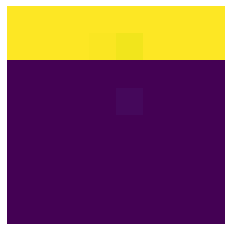

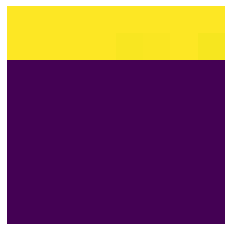

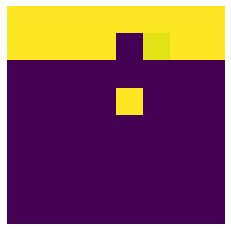

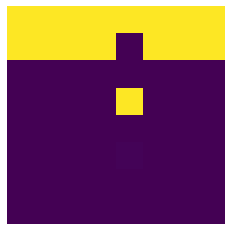

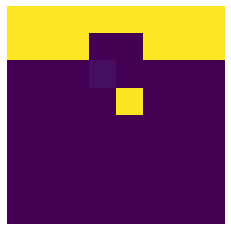

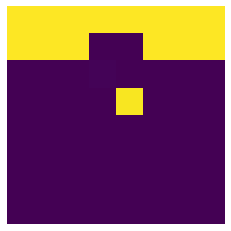

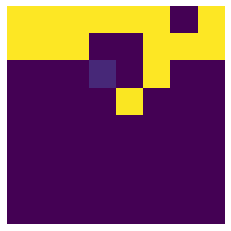

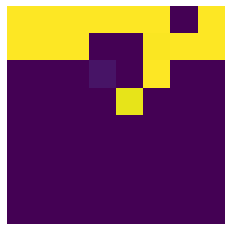

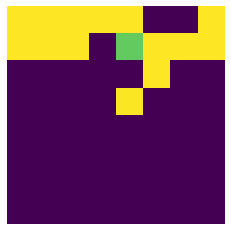

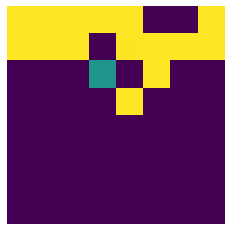

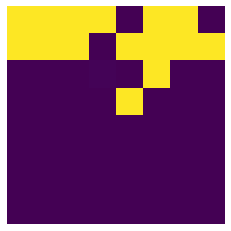

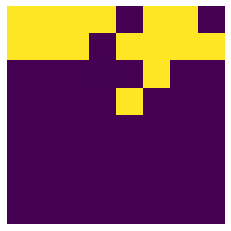

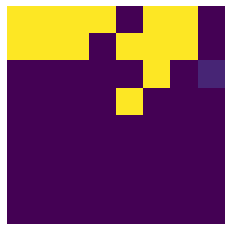

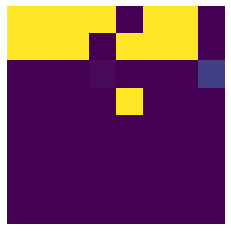

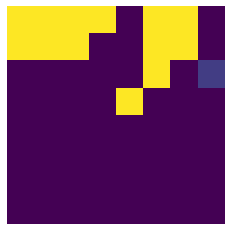

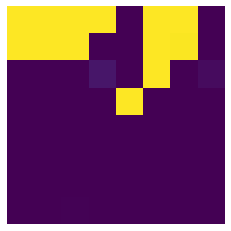

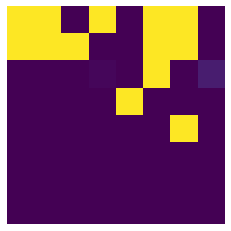

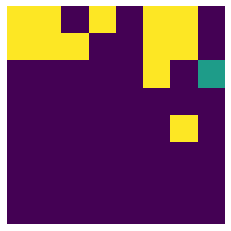

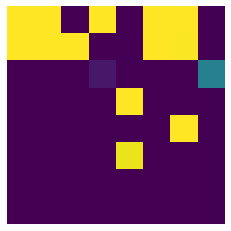

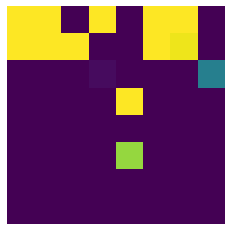

In [57]:
for fields in test['captures']:
    prob = model(np.stack(list(fields.values()))).numpy()[:, 2]
    plt.imshow(prob.reshape(8, 8).T[::-1])
    plt.axis('off')
    plt.show()

## Gaming 'engine'

In [126]:
test_board = chess.Board()

for m in test['game']:
    test_board.push_san(m)
    
test_moves = [str(m) for m in test_board.move_stack]

e2e4 e2e4 True
e7e5 e7e5 True
g1f3 g1f3 True
d7d6 d7d6 True
d2d3 d2d3 True
g8f6 g8f6 True
f1e2 f1e2 True
f8e7 f8e7 True
e1g1 e1g1 True
e8g8 e8g8 True
c1g5 c1g5 True
h7h6 h7h6 True
g5f6 g5f6 True
e7f6 e7f6 True
b1c3 b1c3 True
c8g4 c8g4 True
f3e5 f3e5 True
f6e5 f6e5 True
e2g4 e2g4 True


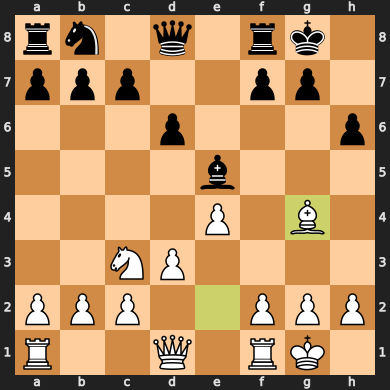

In [130]:
board = chess.Board()

for n, fields in enumerate(test['captures'][1:]):
    probs = {k: v[1 if board.turn else 2] for k, v in predict(model, fields, True).items()}
    legal_moves = [(str(m)[:2], str(m)[2:]) for m in board.legal_moves]
    probs_combo = [probs[b] - probs[a] for a, b in legal_moves]
    move = list(board.legal_moves)[np.argmax(probs_combo)]
    # TODO: implement all 4 possible 0-0
    if ('e1', 'g1') in legal_moves:
        if (probs['h1'] < 0.5) and (probs['e1'] < 0.5) and (probs['f1'] > 0.5) and (probs['g1'] > 0.5):
            move = 'e1g1'
    if ('e8', 'g8') in legal_moves:
        if (probs['h8'] < 0.5) and (probs['e8'] < 0.5) and (probs['f8'] > 0.5) and (probs['g8'] > 0.5):
            move = 'e8g8'
    print(move, test_moves[n], str(move) == test_moves[n])
    board.push_uci(str(move))

assert test_board.move_stack == board.move_stack
board